# Epic War Stats на 30.09.2022

Для того, чтобы показать, что можно делать с результатом работы написаного веб скрапера, я построю пару-тройку графиков по собранным данным. К моменту создания данного Jupyter ноутбука скрапер проработал примерно 60-70 часов и сохранил 100% всех карт в локальную базу PostgreSQL (которая, кстати, в результате весила всего 85.3 Мб).

Начнем с подключения основных библиотек:

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

C помощью psycopg2 приконектимся к PostgreSQL базе и созданим курсор:

In [2]:
conn = psycopg2.connect(dbname="epicwartest", user="postgres", password="123456789")
cursor = conn.cursor()

Первое, что я хотел бы показать, это распределение созданных карт по годовым кварталам. Для этого выполним следюущий запрос. Выберем из таблицы `map` количество карт `maps`, сгуппированное сначала по годам, а затем и по квартам. Отсортируем получившуюся табличку по полю `time`, которое является конкатенацией года, строки 'Q' и номера квартала.

In [30]:
query = """
SELECT 
    COUNT(*) AS maps,
    SUBSTRING(
        CONCAT(
            EXTRACT(year FROM sub), 'Q',
            EXTRACT(quarter FROM sub)
        ), 
    3, 4) as time
FROM map GROUP BY 
    EXTRACT(year FROM sub),
    EXTRACT(quarter FROM sub) 
ORDER BY time
"""
cursor.execute(query)
q_result = cursor.fetchall()
q_result[:10]

[(176, '05Q1'),
 (284, '05Q2'),
 (195, '05Q3'),
 (400, '05Q4'),
 (705, '06Q1'),
 (1478, '06Q2'),
 (2721, '06Q3'),
 (3471, '06Q4'),
 (4899, '07Q1'),
 (6920, '07Q2')]

Теперь обернем `q_result` в `DataFrame`.

In [31]:
df = pd.DataFrame(q_result, columns=['maps', 'time'])
df.iloc[:10]

,maps,time
0,176,05Q1
1,284,05Q2
2,195,05Q3
3,400,05Q4
4,705,06Q1
5,1478,06Q2
6,2721,06Q3
7,3471,06Q4
8,4899,07Q1
9,6920,07Q2


И визуализуем его с помощью `plot.bar`:

Text(0, 0.5, 'Количество карт')

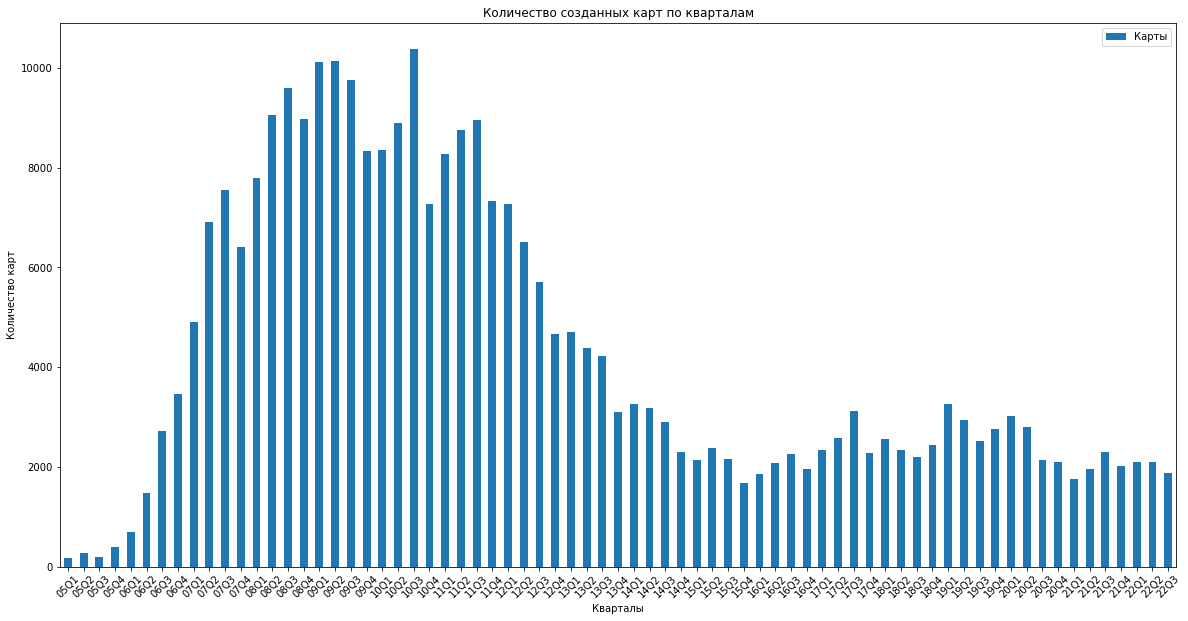

In [32]:
ax = df.plot.bar(x='time', y='maps', figsize=(20,10), rot=45, title='Количество созданных карт по кварталам', label='Карты')
ax.set_xlabel('Кварталы')
ax.set_ylabel('Количество карт')

Как видно из построенной гистрограммы, основной пик активности на сайте приходится на первую половину 2009 года. Именно в это время игроки Warcraft 3 каждые 3 месяца штамповали примерно по 10000 карт, что в среднем соотвествует 108 картам в день или 4-5 картам в час. 

Давайте теперь попробуем как-нибудь раскрасить эту диаграмму. Поделим каждый столбик диаграммы на 10 подгрупп, которые будут отвечать за 10 самых скачиваемых размеров (т.е. карты с этими размерами больше всего скачивают с сайта). Как это сделать? Сформируем следующий запрос. Сначала выберем эти 10 самых скачиваемых размеров `dims`, потом обернем это в запрос, в котором будем менять размер на строчку 'others', если он не входит в десятку. В конце сделаем выборку из последнего запроса, сгруппировав все карты по новым размерам.

In [33]:
query = """
SELECT 
    SUBSTRING(
        CONCAT(
            EXTRACT(year FROM sub), 'Q',
            EXTRACT(quarter FROM sub)
        ), 
    3, 4) as time,
    dims,
    COUNT(*) AS NUMBER
FROM (
    SELECT
        sub,
        CASE
            WHEN dims IN
                (SELECT 
                    CASE WHEN dims IS NULL THEN 'No info' ELSE dims END dims
                FROM MAP
                    GROUP BY dims
                    ORDER BY COUNT(*)
                DESC LIMIT 15)
            THEN dims
            ELSE 'others'
            END dims    
    FROM (
        SELECT 
            sub,
            CASE WHEN dims IS NULL THEN 'No info' ELSE dims END dims
        FROM map
    ) AS a
) AS b
GROUP BY 
    EXTRACT(YEAR FROM sub),
    EXTRACT(quarter FROM sub),
    dims
ORDER BY time, number DESC
"""
cursor.execute(query)
q_result = cursor.fetchall()
q_result[-5:]

[('22Q3', '128x96', 25),
 ('22Q3', '32x32', 22),
 ('22Q3', '160x128', 21),
 ('22Q3', '96x128', 17),
 ('22Q3', '64x96', 5)]

Снова обернем `q_result` в `DataFrame`.

In [34]:
df = pd.DataFrame(q_result, columns=['time', 'dims', 'maps'])
df.iloc[:10]

,time,dims,maps
0,05Q1,96x96,65
1,05Q1,128x128,48
2,05Q1,64x64,14
3,05Q1,others,13
4,05Q1,192x192,11
5,05Q1,255x255,6
6,05Q1,160x160,5
7,05Q1,192x160,3
8,05Q1,96x128,3
9,05Q1,96x64,3


Получилась вот такая вот незамысловая табличка. Теперь, как нам это визуализировать? `plot.bar` с аргументом `stacked=True`  принимает на вход датафрейм, в котором каждая строчка хранит в себе значения всех подгрупп. В нашей же табличке все значения выстроены в один длинный столбец. Чтобы трансформировать табличку в нужный формат, можно поступить следующим образом. Сначала делим табличку на квартальные группы с помощью `groupby`, затем все получившиеся группы транспонируем и снова складываем в один датафрейм, удаляя по пути лишние строчки.

In [35]:
groups = []
for group_name, group in df.groupby(['time']):
    group = group.T.drop(['time'], axis=0)
    group.columns = group.loc['dims']
    group = group.drop(['dims'], axis=0)
    group.index = [group_name]
    groups.append(group)
new_df = pd.concat(groups)
new_df = new_df.assign(others=new_df.pop("others"))
new_df[:10]

dims,96x96,128x128,64x64,192x192,255x255,160x160,192x160,96x128,96x64,224x224,64x96,128x96,160x128,32x32,256x256,others
05Q1,65,48,14,11,6,5,3,3,3,2,2,1,NaN,NaN,NaN,13
05Q2,34,50,26,24,22,26,4,9,3,5,6,6,6,3,NaN,60
05Q3,30,50,18,16,9,27,3,4,NaN,8,4,1,9,1,NaN,15
05Q4,64,80,37,22,35,39,9,16,9,6,13,13,4,2,NaN,51
06Q1,121,169,79,61,43,38,4,13,20,12,15,21,25,6,NaN,78
06Q2,290,263,211,83,161,96,18,20,20,38,27,39,21,20,NaN,171
06Q3,533,484,408,128,222,227,29,48,70,59,42,42,30,62,NaN,337
06Q4,622,613,598,205,228,416,60,37,50,33,31,45,41,93,NaN,399
07Q1,823,790,800,295,398,443,61,90,128,88,83,87,55,141,NaN,617
07Q2,932,1412,1028,403,666,611,76,154,158,171,85,179,87,151,NaN,807


Теперь можно визуалзировать `new_df`. О значениях `NaN` можно не беспокоится, `plot.bar` их просто не отобразит.

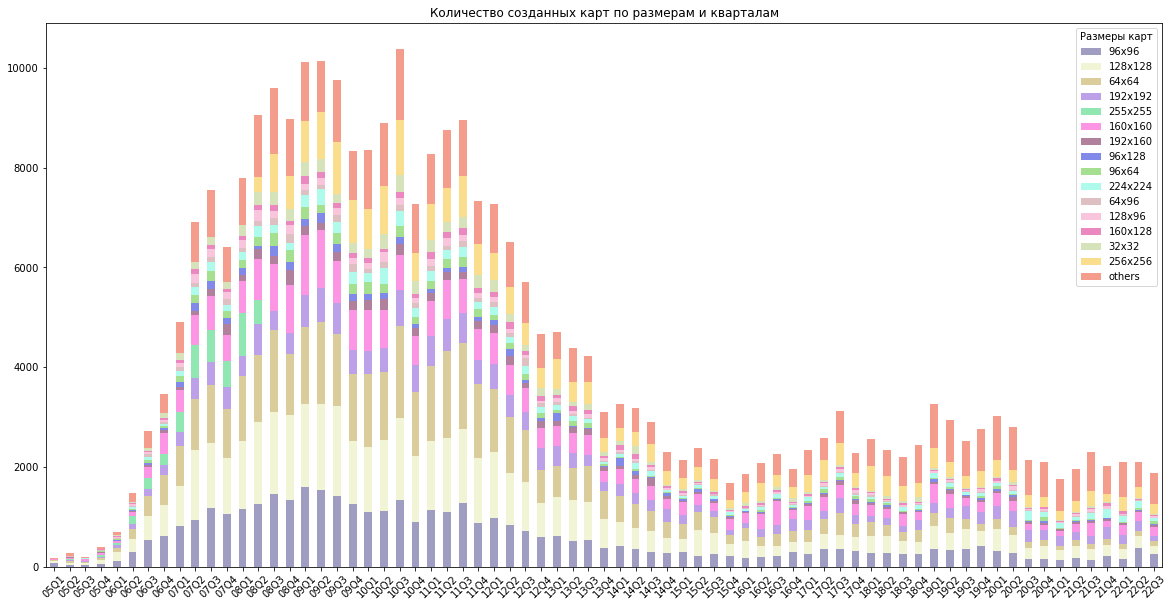

In [38]:
from matplotlib.colors import ListedColormap
import random
def random_colormap(size):
    colors = []
    rnd = lambda: random.uniform(0, 1) * .5 + .5
    while len(colors) < size:
        new_c = [rnd(), rnd(), rnd()]
        far = True
        for ex_c in colors:
            if abs(ex_c[0]-new_c[0]) + abs(ex_c[1]-new_c[1]) + abs(ex_c[2]-new_c[2]) < .2:
                far = False
                break
        if far and (abs(new_c[0]-new_c[1]) > .1 or abs(new_c[0]-new_c[2]) > .1 or abs(new_c[1]-new_c[2]) > .1):
            colors.append(new_c)      
    return ListedColormap(colors)

cmap = random_colormap(16)
ax = new_df.plot.bar(figsize=(20,10), rot=45, stacked=True, title='Количество созданных карт по размерам и кварталам', cmap = cmap)
title = plt.legend(title = 'Размеры карт')

Эта гистограмма выглядит уже чуть поинтереснее. Сразу видно, что в среднем соотношение подгрупп остается неизменным от квартала к кварталу. Большинство карт создаются с размерами 96x96, 128x128 и 64x64.

Теперь проделаем все то же самое, но только для категорий карт. Не будем из них выделять лучшие т.к. их совсем немного.

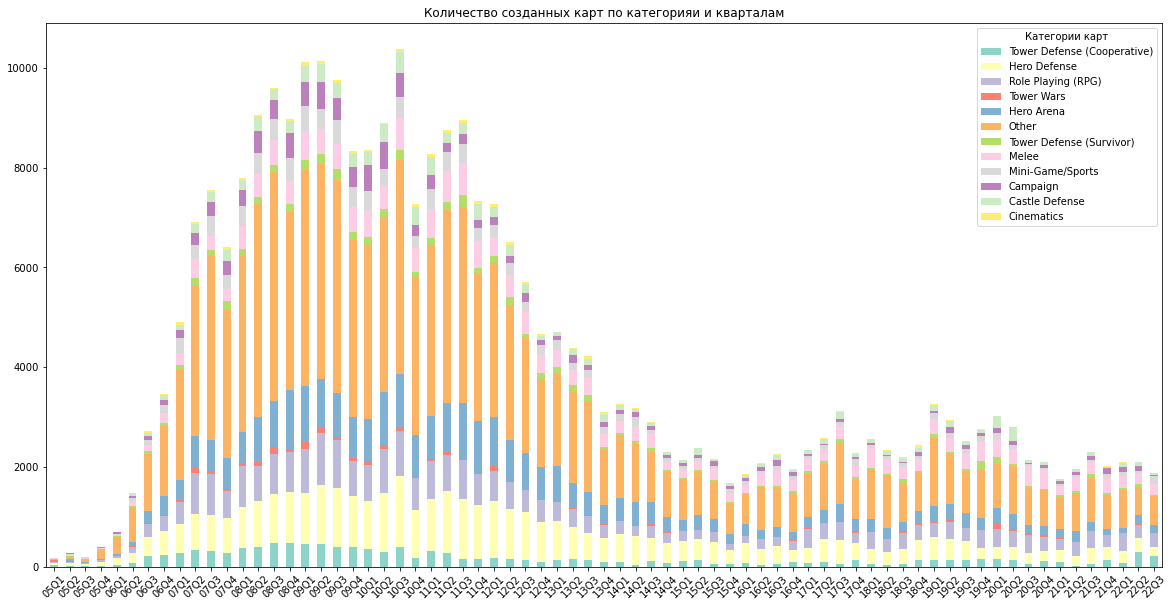

In [39]:
query = """
SELECT 
    SUBSTRING(
        CONCAT(
            EXTRACT(year FROM sub), 'Q',
            EXTRACT(quarter FROM sub)
        ), 
    3, 4) as time,
    category,
    COUNT(*) AS NUMBER
FROM map
GROUP BY 
    EXTRACT(YEAR FROM sub),
    EXTRACT(quarter FROM sub),
    category
ORDER BY time, number DESC
"""
cursor.execute(query)
q_result = cursor.fetchall()
df = pd.DataFrame(q_result, columns=['time', 'category', 'maps'])
groups = []
for group_name, group in df.groupby(['time']):
    group = group.T.drop(['time'], axis=0)
    group.columns = group.loc['category']
    group = group.drop(['category'], axis=0)
    group.index = [group_name]
    groups.append(group)
new_df = pd.concat(groups)
ax = new_df.plot.bar(figsize=(20,10), rot=45, stacked=True, title='Количество созданных карт по категорияи и кварталам', colormap = 'Set3')
title = plt.legend(title = 'Категории карт')

Да, на протяжении всего существования сайта игроки постоянно пытались создавать что-то новое :) Помимо Other, популярными категориями являлись также категории Hero Defence и Hero Area.

Ну и на последок раскрасим гистограмму еще и по тайлсетам.

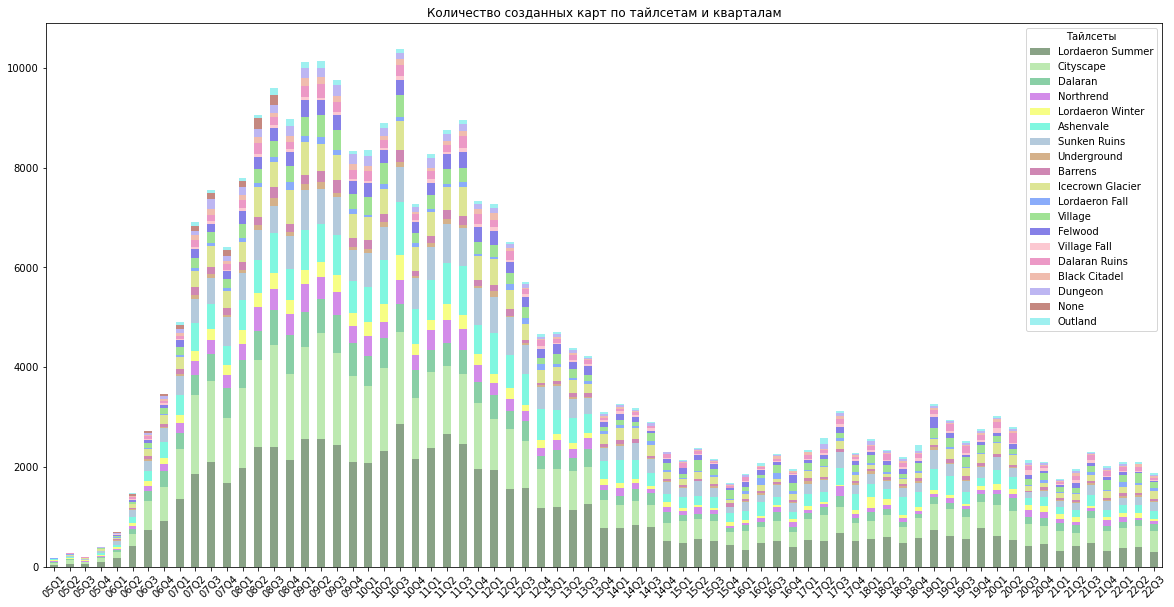

In [45]:
query = """
SELECT 
    SUBSTRING(
        CONCAT(
            EXTRACT(year FROM sub), 'Q',
            EXTRACT(quarter FROM sub)
        ), 
    3, 4) as time,
    tileset,
    COUNT(*) AS NUMBER
FROM map
GROUP BY 
    EXTRACT(YEAR FROM sub),
    EXTRACT(quarter FROM sub),
    tileset
ORDER BY time, number DESC
"""
cursor.execute(query)
q_result = cursor.fetchall()
df = pd.DataFrame(q_result, columns=['time', 'tileset', 'maps'])
groups = []
for group_name, group in df.groupby(['time']):
    group = group.T.drop(['time'], axis=0)
    group.columns = group.loc['tileset']
    group = group.drop(['tileset'], axis=0)
    group.index = [group_name]
    groups.append(group)
new_df = pd.concat(groups)
cmap = random_colormap(25)
ax = new_df.plot.bar(figsize=(20,10), rot=45, stacked=True, title='Количество созданных карт по тайлсетам и кварталам', cmap=cmap)
title = plt.legend(title = 'Тайлсеты')

Тут также можно проследить некий тренд в создании карт - чаще всего используются тайлсеты Lordearon Summer и Cityspace.

Давайте теперь поищем пары атрибутов самых создаваемых, самых высокооцененных и самых скачиваемых карт. Визуализировать все это будем с помощью `heatmap` из библиотеки Seaborn.

In [12]:
import seaborn as sns

Сделаем к базе запрос, в котором сгруппируем все карты по категориям, размерам и тайлсетам. Для каждой группы рассчитаем общее количество созданных карт, количество оценок "Good" и количество загрузок.

In [13]:
query = """
SELECT
    category,
    dims,
    tileset,
    COUNT(*), 
    SUM(good), 
    SUM(downloads)
FROM map
WHERE dims in (
        SELECT dims
        FROM map
        GROUP BY dims
        ORDER BY SUM(downloads) DESC
        LIMIT 15
    )
GROUP BY
    category,
    dims,
    tileset
ORDER BY
    SUM(downloads) DESC
"""
cursor.execute(query)
q_result = cursor.fetchall()
df = pd.DataFrame(q_result, columns=['category', 'dims', 'tileset', 'number', 'good', 'downloads'])
df[:10]

,category,dims,tileset,number,good,downloads
0,Hero Defense,128x128,Felwood,1993,68053,29832745
1,Other,128x128,Felwood,1107,53543,29143112
2,Hero Arena,64x96,Cityscape,175,16458,8445497
3,Hero Arena,224x224,Ashenvale,114,20012,7820069
4,Other,192x160,Dalaran,860,17602,7644969
5,Tower Defense (Cooperative),96x96,Village,1858,15139,6541524
6,Hero Arena,192x160,Dalaran,1237,21124,6234850
7,Hero Defense,128x96,Dalaran,173,17896,5640252
8,Other,96x96,Lordaeron Summer,4477,16204,4731367
9,Hero Defense,96x96,Northrend,253,9055,4320299


Получился своеобразный топ-10 самых скачиваемых конфигураций карт. Теперь из этого датафрейма, нам нужно составить целых 9 табличек, в колонках и индексах которых будут находится значения пар атрибутов, а в ячеках - суммы значений из колонок number, good и downloads. Для этого мы сначала в cl_sets сохраняем множества значений всех рассматирваемых атрибутов карт.

In [14]:
cl_sets = {
    'categories': df.groupby(['category']).groups.keys(),
    'dims': df.groupby(['dims']).groups.keys(),
    'tileset': df.groupby(['tileset']).groups.keys(),
}
cl_sets

{'categories': dict_keys(['Campaign', 'Castle Defense', 'Cinematics', 'Hero Arena', 'Hero Defense', 'Melee', 'Mini-Game/Sports', 'Other', 'Role Playing (RPG)', 'Tower Defense (Cooperative)', 'Tower Defense (Survivor)', 'Tower Wars']),
 'dims': dict_keys(['128x128', '128x96', '160x128', '160x160', '192x160', '192x192', '224x224', '255x255', '256x256', '64x64', '64x96', '96x224', '96x64', '96x96']),
 'tileset': dict_keys(['Ashenvale', 'Barrens', 'Black Citadel', 'Cityscape', 'Dalaran', 'Dalaran Ruins', 'Dungeon', 'Felwood', 'Icecrown Glacier', 'Lordaeron Fall', 'Lordaeron Summer', 'Lordaeron Winter', 'Northrend', 'Outland', 'Sunken Ruins', 'Underground', 'Village', 'Village Fall'])}

Затем создаем пустые таблички и заполнаяем их (бежим по всему изначальному датафрейму). 

In [15]:
number_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['dims']).astype(float).fillna(0)
good_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['dims']).astype(float).fillna(0)
downloads_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['dims']).astype(float).fillna(0)
for indx, row in df.iterrows():
    number_df.loc[row.iloc[1], row.iloc[0]] += row.iloc[3] 
    good_df.loc[row.iloc[1], row.iloc[0]] += row.iloc[4] 
    downloads_df.loc[row.iloc[1], row.iloc[0]] += row.iloc[5] 
number_df

,Campaign,Castle Defense,Cinematics,Hero Arena,Hero Defense,Melee,Mini-Game/Sports,Other,Role Playing (RPG),Tower Defense (Cooperative),Tower Defense (Survivor),Tower Wars
128x128,1440.0,1534.0,255.0,4889.0,10267.0,3023.0,1685.0,18565.0,1870.0,2475.0,1576.0,576.0
128x96,223.0,278.0,35.0,803.0,1013.0,395.0,119.0,1564.0,127.0,91.0,121.0,63.0
160x128,193.0,105.0,8.0,402.0,1028.0,323.0,41.0,1532.0,254.0,95.0,54.0,9.0
160x160,1363.0,796.0,121.0,2350.0,3707.0,2994.0,584.0,11150.0,3135.0,609.0,534.0,165.0
192x160,139.0,64.0,26.0,2583.0,478.0,526.0,80.0,2048.0,180.0,24.0,22.0,15.0
192x192,728.0,479.0,72.0,1379.0,1377.0,3746.0,728.0,8967.0,2489.0,178.0,336.0,56.0
224x224,428.0,164.0,25.0,449.0,691.0,874.0,57.0,3012.0,1852.0,47.0,46.0,9.0
255x255,206.0,64.0,11.0,140.0,73.0,158.0,51.0,1830.0,1726.0,5.0,13.0,3.0
256x256,924.0,376.0,104.0,1175.0,959.0,2099.0,316.0,10917.0,7896.0,239.0,176.0,38.0
64x64,1139.0,1226.0,560.0,6456.0,4491.0,2429.0,3482.0,21257.0,1082.0,1141.0,620.0,244.0


Теперь построим три отдельных heatmap'a для каждой из трех последних колонок исходного датафрейма.

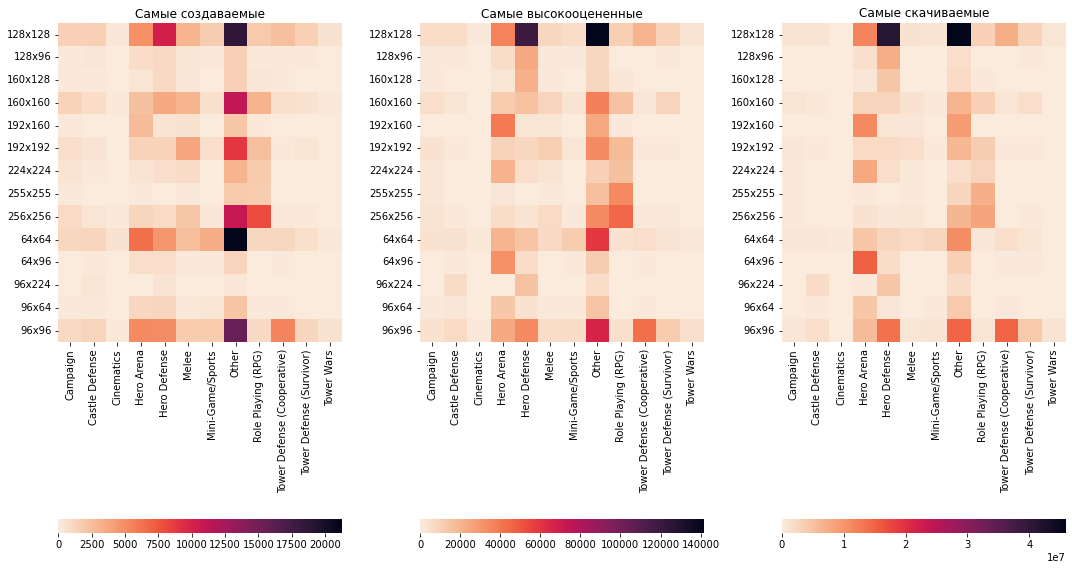

In [16]:
fig, axs = plt.subplots(ncols=3, figsize=(15,8))
hm_cbar_kws = dict(location="bottom",anchor=(0,-1))
color_map = "rocket_r"
sns.heatmap(number_df, ax=axs[0],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые создаваемые')
sns.heatmap(good_df, ax=axs[1],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые высокооцененные')
sns.heatmap(downloads_df, ax=axs[2],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые скачиваемые')
fig.tight_layout()

Что мы здесь видим? Чем темнее ячейки на картах, тем большее количество карт, количество отметок "Good" или количество загрузок имеют карты тех аттрибутов, на пересечениях колонок и строк которых расположены эти ячейки. На первой карте можно увидеть, что на сайте больше всего карт категории Other размеров 64x64, 128x128 и 96x96. В то же время самыми высокооценными и самыми скачиваемыми являются категории Other и Hero Defence размера 128x128. Т.е. карты Other 64x64 и Other 96x96 хоть и создаются чаще чем Other 128x128 , но оцениваются и тем более скачиваются они намного реже. И наоборот, карты Hero Defence 128x128 создают реже, но оценок Good и загрузок у них больше чем, например, у Other 96x96.

Теперь построим те же карты, но вместо размеров будем использовать тайлсеты.

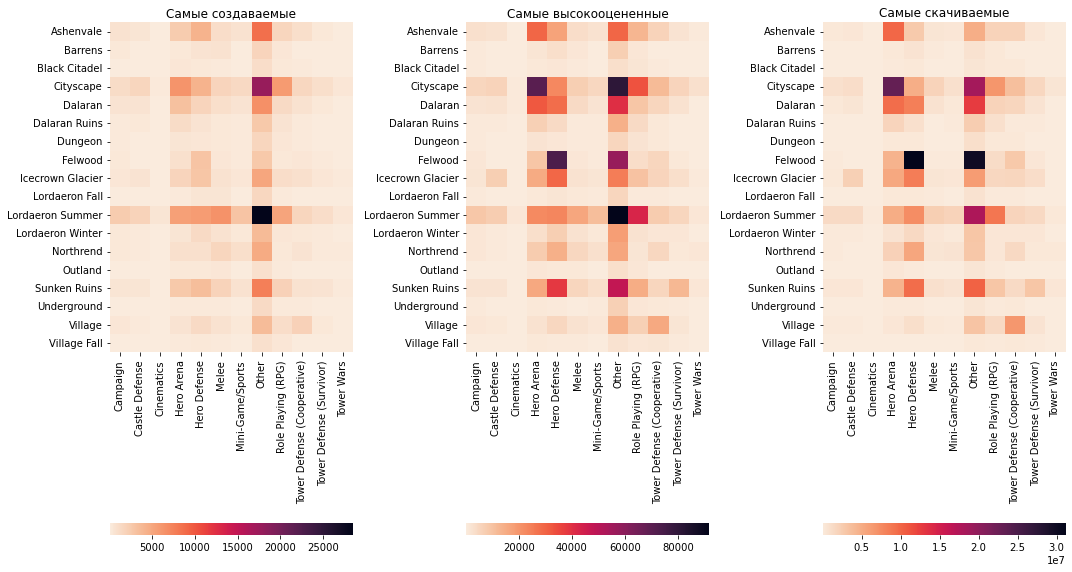

In [17]:
number_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['tileset']).astype(float).fillna(0)
good_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['tileset']).astype(float).fillna(0)
downloads_df = pd.DataFrame(columns=cl_sets['categories'], index=cl_sets['tileset']).astype(float).fillna(0)
for indx, row in df.iterrows():
    number_df.loc[row.iloc[2], row.iloc[0]] += row.iloc[3] 
    good_df.loc[row.iloc[2], row.iloc[0]] += row.iloc[4] 
    downloads_df.loc[row.iloc[2], row.iloc[0]] += row.iloc[5] 
fig, axs = plt.subplots(ncols=3, figsize=(15,8))
hm_cbar_kws =  dict(location="bottom",anchor=(0,-.7))
color_map = "rocket_r"
sns.heatmap(number_df, ax=axs[0],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые создаваемые')
sns.heatmap(good_df, ax=axs[1],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые высокооцененные')
sns.heatmap(downloads_df, ax=axs[2],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые скачиваемые')
fig.tight_layout()

Тут примерно та же картина. Карты категории Other c тайлсетом Lordaeron Summer создают и оценивают чаще всех, но при этом же они не явлются лидерами по загрузкам. А карты, которые чаще скачиваются, например Felwood категорий Hero Defense и Other, создаются намного реже чем те же карты категории Other но с тайлсетами Lordaeron Summer и Cityscape.

Третьей и последней парой атрибутов, которую мы рассмотрим, будут тайсеты с размерами.

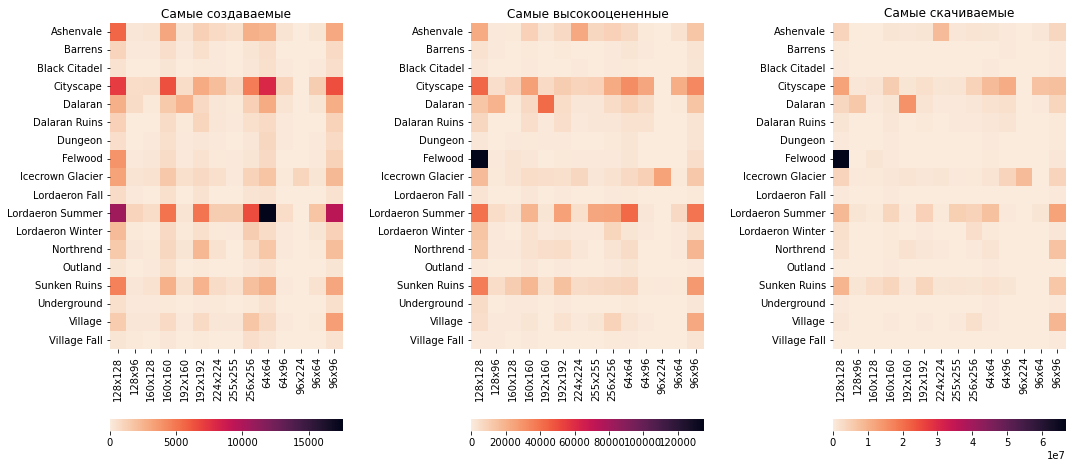

In [18]:
number_df = pd.DataFrame(columns=cl_sets['dims'], index=cl_sets['tileset']).astype(float).fillna(0)
good_df = pd.DataFrame(columns=cl_sets['dims'], index=cl_sets['tileset']).astype(float).fillna(0)
downloads_df = pd.DataFrame(columns=cl_sets['dims'], index=cl_sets['tileset']).astype(float).fillna(0)
for indx, row in df.iterrows():
    number_df.loc[row.iloc[2], row.iloc[1]] += row.iloc[3] 
    good_df.loc[row.iloc[2], row.iloc[1]] += row.iloc[4] 
    downloads_df.loc[row.iloc[2], row.iloc[1]] += row.iloc[5] 
fig, axs = plt.subplots(ncols=3, figsize=(15,7))
hm_cbar_kws =  dict(location="bottom",anchor=(0,1))
color_map = "rocket_r"
sns.heatmap(number_df, ax=axs[0],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые создаваемые')
sns.heatmap(good_df, ax=axs[1],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые высокооцененные')
sns.heatmap(downloads_df, ax=axs[2],cbar_kws = hm_cbar_kws, cmap=color_map).set(title='Самые скачиваемые')
fig.tight_layout()

Смотрим здесь, карты с тайлсетом Lordaeron Summer независимо от размеров создаются очень часто, но оцениваются и скачиваются редко. А вот карты Felwood размера 128x128 хоть и лидируют по оценками и загрузкам, но почти не появляются на сайте.

Теперь, резюмируя все выше написаное, можно сказать, что:
1. Чаще всего создаются карты категории Other c тайлсетами Lordaeron Summer и Cityscape и размерами 64x64, 96x96 и 128x128;
2. Чаще всего скачиваются и оцениваются карты категорий Other и Hero Defense c тайлсетами Felweed и Cityscape размера 128x128.

Ну и напоследок вернемся к топ-10 скачиваемых конфигураций.

In [19]:
df[:10]

,category,dims,tileset,number,good,downloads
0,Hero Defense,128x128,Felwood,1993,68053,29832745
1,Other,128x128,Felwood,1107,53543,29143112
2,Hero Arena,64x96,Cityscape,175,16458,8445497
3,Hero Arena,224x224,Ashenvale,114,20012,7820069
4,Other,192x160,Dalaran,860,17602,7644969
5,Tower Defense (Cooperative),96x96,Village,1858,15139,6541524
6,Hero Arena,192x160,Dalaran,1237,21124,6234850
7,Hero Defense,128x96,Dalaran,173,17896,5640252
8,Other,96x96,Lordaeron Summer,4477,16204,4731367
9,Hero Defense,96x96,Northrend,253,9055,4320299


Давайте для каждой конфигурации выведем топ-10 скачиваемых карт.  
Для первого места это будут карты:

In [20]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Defense' AND
    dims = '128x128' AND
    tileset = 'Felwood'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,DotA v6.69b LoD v8c,IceFrog,2011-05-13 07:28:00,1071708,https://epicwar.com/maps/171208
1,DotA Allstars v6.67c,IceFrog,2010-03-30 19:41:00,1040455,https://epicwar.com/maps/129468
2,DotA v6.74c,IceFrog,2012-03-21 16:36:00,1034019,https://epicwar.com/maps/200871
3,DotA v6.74c LoD v5d,IceFrog,2012-05-23 05:17:00,964011,https://epicwar.com/maps/205784
4,DotA v6.74c LoD v5e,IceFrog,2012-05-30 01:54:00,962275,https://epicwar.com/maps/206329
5,DotA v6.71b,IceFrog,2011-01-23 21:24:00,917264,https://epicwar.com/maps/160217
6,DotA Allstars v6.59c,IceFrog,2009-02-14 00:24:00,803179,https://epicwar.com/maps/84557
7,DotA v6.80c,IceFrog,2014-03-04 07:43:00,753886,https://epicwar.com/maps/240366
8,DotA Allstars v6.59b,IceFrog,2009-02-01 20:15:00,749837,https://epicwar.com/maps/83141
9,DotA v6.70c AI,IceFrog,2011-04-14 04:39:00,684364,https://epicwar.com/maps/168316


Для второго места:

In [21]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Other' AND
    dims = '128x128' AND
    tileset = 'Felwood'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,DotA Allstars v6.61c,IceFrog,2009-08-05 21:12:00,1377743,https://epicwar.com/maps/105639
1,DotA v6.74c AI 1.3,IceFrog,2012-04-02 16:18:00,1098357,https://epicwar.com/maps/201873
2,DotA v6.78c,IceFrog,2013-07-01 12:15:00,1065385,https://epicwar.com/maps/230066
3,DotA v6.72f,IceFrog,2011-07-22 02:16:00,1034699,https://epicwar.com/maps/179108
4,DotA v6.72c,IceFrog,2011-06-03 05:05:00,757399,https://epicwar.com/maps/173537
5,DotA v6.68c,IceFrog,2010-08-03 23:22:00,730387,https://epicwar.com/maps/143662
6,DotA Imba AI 3.73.3c English Version,IceFrog (AI by BuffMePlz),2011-01-07 20:14:00,722778,https://epicwar.com/maps/158784
7,DotA Allstars v6.43b AI+ v.1.4,IceFrog,2007-05-06 09:20:00,701593,https://epicwar.com/maps/18786
8,DotA Allstars v6.67b AI,IceFrog,2010-06-08 02:30:00,671078,https://epicwar.com/maps/136480
9,DotA Allstars v6.59d,IceFrog,2009-03-21 06:36:00,650961,https://epicwar.com/maps/88879


Для третьего места:

In [22]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Arena' AND
    dims = '64x96' AND
    tileset = 'Cityscape'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Map Tong Hop V 49.0,zMidouz,2010-04-02 01:46:00,6915377,https://epicwar.com/maps/129683
1,Map Tong Hop V 49.0,zMidouz,2010-04-18 14:11:00,215841,https://epicwar.com/maps/131393
2,Map Tong Hop V 50.0,Vu Hoai Son,2009-10-26 06:07:00,117665,https://epicwar.com/maps/113994
3,Map Tong Hop V 47.0,zMidouz,2009-09-18 13:53:00,110876,https://epicwar.com/maps/110554
4,Map Tong Hop V 49.0,zMidouz,2010-04-30 00:14:00,97829,https://epicwar.com/maps/132367
5,MAP TONG HOP 2,none,2008-08-22 05:56:00,86758,https://epicwar.com/maps/65095
6,Map Tong Hop v 67.0,Vu Hoai Son,2010-06-13 10:40:00,84374,https://epicwar.com/maps/137121
7,Map tong hop v 58.0,Vu Hoai Son,2009-12-07 05:59:00,65440,https://epicwar.com/maps/117863
8,Map Tong Hop V 49.0,zMidouz,2010-10-08 13:07:00,53952,https://epicwar.com/maps/151030
9,MAP TONG HOP 3,_ProKing_(Hoc Mon),2008-08-22 06:31:00,50836,https://epicwar.com/maps/65097


Для четвертого места:

In [23]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Arena' AND
    dims = '224x224' AND
    tileset = 'Ashenvale'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Thien Kiem v6.5,Rex - Garena.vn,2011-12-20 05:09:00,1170716,https://epicwar.com/maps/192923
1,Kiem The v5.3,Rex - gamevn.com,2010-12-11 05:11:00,874586,https://epicwar.com/maps/156258
2,Thien Kiem v6.2,vnakira - Garena.vn,2011-05-26 02:37:00,591141,https://epicwar.com/maps/172558
3,Thien Kiem v6.3,Rex - Garena.vn,2011-08-01 05:13:00,442924,https://epicwar.com/maps/180213
4,Kiem The v5.0,Rex - gamevn.com,2010-10-12 02:00:00,434501,https://epicwar.com/maps/151356
5,Kiem The v4.7,Rex - gamevn.com,2010-08-18 05:49:00,414271,https://epicwar.com/maps/145518
6,Thien Kiem v6.4c,Rex - Garena.vn,2011-10-20 02:40:00,412302,https://epicwar.com/maps/187822
7,Thien Kiem v6.0,vnakira - Garena.vn,2011-04-23 03:57:00,365120,https://epicwar.com/maps/169176
8,Kiem The v4.6,Rex - gamevn.com,2010-07-23 06:57:00,352236,https://epicwar.com/maps/142126
9,Thien Kiem v6.3b,Rex - Garena.vn,2011-09-10 23:49:00,263765,https://epicwar.com/maps/184433


Для пятого места:

In [24]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Other' AND
    dims = '192x160' AND
    tileset = 'Dalaran'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Legend Of The Dragon v1000,Athar,2009-03-05 10:51:00,1791944,https://epicwar.com/maps/87069
1,Legend Of The Dragon v78.0,zMidouz,2008-11-04 13:56:00,648272,https://epicwar.com/maps/72328
2,legend of the dragon v86.0,J3oyWar,2008-11-10 05:58:00,401067,https://epicwar.com/maps/73070
3,Legend Of The Dragon v53.0,zMidouz,2008-09-23 20:03:00,165072,https://epicwar.com/maps/68474
4,Legend Of The Dragon v65.0,zMidouz,2008-11-01 06:20:00,161000,https://epicwar.com/maps/71837
5,Legend Of The Dragon v2000,Athar,2010-07-09 11:06:00,154728,https://epicwar.com/maps/140273
6,LegendOfTheDragon v10000,YeAh,2009-11-14 19:55:00,149093,https://epicwar.com/maps/115899
7,Legend Of The Dragon v65.0,zMidouz,2008-11-02 02:53:00,128750,https://epicwar.com/maps/72002
8,Legend of the Dragon,Tri,2010-03-17 20:48:00,122092,https://epicwar.com/maps/128230
9,Legend Of The Dragon Ball,zMidouz\haru2000,2008-11-15 01:35:00,120274,https://epicwar.com/maps/73600


Для шестого места:

In [25]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Tower Defense (Cooperative)' AND
    dims = '96x96' AND
    tileset = 'Village'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Green Circle TD Mega 10.5,Base on Doom,2011-07-21 13:17:00,353880,https://epicwar.com/maps/179039
1,Green TD ZeRo V.0,T3mpe5t[HyE],2006-12-18 09:39:00,233064,https://epicwar.com/maps/9836
2,Green TD h.4.1,"hollowoutside,Darky712",2005-05-24 11:35:00,183147,https://epicwar.com/maps/319
3,Green Circle TD Mega 10.9,Base on Doom,2012-04-14 20:21:00,176434,https://epicwar.com/maps/202804
4,Green TD 5,[cx],2006-06-08 11:18:00,150739,https://epicwar.com/maps/3139
5,Green Circle TD V 3.1,hit and JaredR26,2007-08-29 14:17:00,119601,https://epicwar.com/maps/29931
6,Green Circle TD v.6.2.5,Kai wa,2011-02-12 14:52:00,107208,https://epicwar.com/maps/162234
7,Green TD ZeRo V.0.5,EriKa[1],2007-01-06 15:24:00,105690,https://epicwar.com/maps/10895
8,Green Circle TD Mega 10.1,Base on Doom,2011-05-20 07:57:00,90871,https://epicwar.com/maps/171948
9,Green TD,Metro95,2006-09-04 20:03:00,86553,https://epicwar.com/maps/5711


Для седьмого места:

In [26]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Arena' AND
    dims = '192x160' AND
    tileset = 'Dalaran'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Angel Arena Devil VS Angel v3.3,Piantes John,2007-05-23 20:20:00,216827,https://epicwar.com/maps/20072
1,Legend Of The Dragon v60.0,zMidouz,2008-10-17 16:51:00,184200,https://epicwar.com/maps/71015
2,legend of the dragon v84.0,J3oyWar,2008-11-06 04:32:00,156180,https://epicwar.com/maps/72542
3,Legend Of The Dragon v58.0,zMidouz,2008-10-09 00:53:00,152206,https://epicwar.com/maps/70164
4,Legend Of The Dragon Ball v7.0,zMidouz\haru2000/ryobakuya,2008-11-18 14:11:00,143309,https://epicwar.com/maps/74080
5,Legend Of The Dragon v9999,Progamevn2008(athar),2011-08-09 14:00:00,114753,https://epicwar.com/maps/181176
6,Legend Of The Dragon v54.0,zMidouz,2008-09-24 06:42:00,113849,https://epicwar.com/maps/68503
7,Legend Dragon GT v1050,Osin,2009-06-09 03:00:00,83678,https://epicwar.com/maps/98559
8,Legend Dragon GT v1120,Osin,2009-07-26 10:03:00,82860,https://epicwar.com/maps/104375
9,Angel Arena v3.10,Lil_Devil_Child,2005-02-24 08:42:00,81374,https://epicwar.com/maps/10


Для восьмого места:

In [27]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Defense' AND
    dims = '128x96' AND
    tileset = 'Dalaran'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,DDay: Judgement 19.9b,Dh-Neo,2006-11-13 20:25:00,3783111,https://epicwar.com/maps/8240
1,DDay: Judgement 19.6F,Dh-Neo,2006-06-22 22:50:00,290591,https://epicwar.com/maps/3440
2,Dday: Judgement 20.0b,DDayteam,2007-10-18 19:18:00,281312,https://epicwar.com/maps/33442
3,DDay: Judgement 19.9f,DDayteam?,2007-08-02 03:04:00,199882,https://epicwar.com/maps/27163
4,DDay: Xtremme 1.3b,Dh-Neo,2006-12-08 18:14:00,185512,https://epicwar.com/maps/9374
5,DDay: Judgement 19.9b Mid,Dh-Neo,2013-01-11 05:51:00,96352,https://epicwar.com/maps/220690
6,DDay: Judgement 19.4F,Dh-Neo,2006-04-15 20:29:00,88958,https://epicwar.com/maps/2125
7,DDay: Judgement 19.2F,Dh-Neo,2006-02-17 05:54:00,84849,https://epicwar.com/maps/1493
8,DDay: Judgement 19.8F,Dh-Neo,2006-11-01 22:36:00,84070,https://epicwar.com/maps/7840
9,DDay: Judgement 19.0F,Dh-Neo,2006-01-20 01:18:00,73007,https://epicwar.com/maps/1287


Для девятого места:

In [28]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Other' AND
    dims = '96x96' AND
    tileset = 'Lordaeron Summer'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Divide & Fight v2.04i,NgoaLong,2012-04-26 03:27:00,352042,https://epicwar.com/maps/203701
1,Divide & Fight v2.07c,Leo Oblivion,2012-07-22 08:05:00,298148,https://epicwar.com/maps/210270
2,Divide & Fight v2.05c,NgoaLong,2012-05-19 02:30:00,291408,https://epicwar.com/maps/205456
3,Divide & Fight v2.06d,Leo Oblivion,2012-06-27 15:23:00,167843,https://epicwar.com/maps/208474
4,Divide & Fight v2.06b,Leo Oblivion,2012-06-13 10:41:00,101276,https://epicwar.com/maps/207420
5,????NARUTO-6.2-AE,???? & ????,2005-10-14 04:25:00,93924,https://epicwar.com/maps/732
6,Divide & Fight v2.09d,Leo Oblivion,2012-09-11 10:28:00,80913,https://epicwar.com/maps/213898
7,Divide & Fight v2.07,Leo Oblivion,2012-07-13 12:58:00,80308,https://epicwar.com/maps/209664
8,Divide & Fight v2.19c,Leo Oblivion,2013-11-27 02:04:00,75523,https://epicwar.com/maps/236555
9,BattleStadium DON1.8b,Valkemiere,2012-08-19 02:36:00,73418,https://epicwar.com/maps/212329


Ну и для десятого места:

In [29]:
query = """
SELECT
    name,
    author, 
    sub,
    downloads,
    CONCAT('https://epicwar.com/maps/', id) AS link
FROM map
WHERE
    category = 'Hero Defense' AND
    dims = '96x96' AND
    tileset = 'Northrend'
ORDER by
    downloads DESC
LIMIT 10
"""
cursor.execute(query)
pd.DataFrame(cursor.fetchall(), columns=['name', 'author', 'date', 'downloads', 'link'])

,name,author,date,downloads,link
0,Divide & Fight v1.26c,Lowji 107,2011-06-18 06:42:00,549472,https://epicwar.com/maps/175153
1,Divide & Fight v1.27,Lowji 107,2011-08-17 06:51:00,401858,https://epicwar.com/maps/181994
2,Divide & Fight v1.30b,NgoaLong,2011-11-03 07:21:00,380625,https://epicwar.com/maps/188955
3,Divide & Fight v1.24,Lowji 107,2011-04-21 05:57:00,336860,https://epicwar.com/maps/168991
4,Divide & Fight v1.28b,phutu,2011-09-30 14:31:00,226603,https://epicwar.com/maps/186005
5,Cops & Robbers AI 1.05,-none-,2008-10-03 07:52:00,183300,https://epicwar.com/maps/69457
6,Divide & Fight v2.01c,NgoaLong,2012-01-11 08:09:00,175012,https://epicwar.com/maps/194666
7,Divide & Fight v2.01,NgoaLong,2011-12-31 15:19:00,171752,https://epicwar.com/maps/193904
8,Divide & Fight v1.25c,Lowji 107,2011-05-18 05:53:00,160879,https://epicwar.com/maps/171738
9,Divide & Fight v1.28,phutu,2011-09-23 11:08:00,149009,https://epicwar.com/maps/185460


В итоге получаем топ-10 скачиваемых карт (почти) разных конфигураций:
1. DotA v6.69b LoD v8c (https://epicwar.com/maps/171208), автор: IceFrog, появилась: 2011-05-13 в 07:28:00 
2. DotA Allstars v6.61c (https://epicwar.com/maps/105639), автор: IceFrog, появилась: 2009-08-05 в 21:12:00
3. Map Tong Hop V 49.0 (https://epicwar.com/maps/129683), автор: zMidouz, появилась: 2010-04-02 в 01:46:00
4. Thien Kiem v6.5 (https://epicwar.com/maps/192923), автор: Rex - Garena.vn, появлась: 2011-12-20 в 05:09:00
5. Legend Of The Dragon v1000 (https://epicwar.com/maps/87069), автор Athar, появилась: 2009-03-05 в 10:51:00 
6. Green Circle TD Mega 10.5 (https://epicwar.com/maps/179039), автор Base on Doom, появилась: 2011-07-21 в 13:17:00
7. Angel Arena Devil VS Angel v3.3 (https://epicwar.com/maps/20072), автор Piantes John, появилась: 2007-05-23 в 20:20:00
8. DDay: Judgement 19.9b (https://epicwar.com/maps/8240), автор: Dh-Neo, появилась:	2006-11-13 в 20:25:00
9. Divide & Fight v2.04i (https://epicwar.com/maps/203701), автор: NgoaLong, появилась: 2012-04-26 в 03:27:00
10. Divide & Fight v1.26c (https://epicwar.com/maps/175153), автор:	Lowji 107, появилась: 2011-06-18 в 06:42:00

Вот, на этом пока все. Надеюсь, что для кого-нибудь эта информация была интересной :)